Reads and parses fNIRS data with traditional ML techniques

In [72]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
fnirs_path = os.path.join(os.getcwd(), "data/S902/2015-02-26_11-24-48-120", "fNIRSdata.txt")
marker_path = os.path.join(os.getcwd(), "data/S902/2015-02-26_11-24-48-120", "markers.txt")

First read the files

In [3]:
fnirs_df = pd.read_csv(fnirs_path, sep='\t', skiprows=range(4), index_col=False)

In [4]:
marker_df = pd.read_csv(marker_path, sep='\t', skiprows=range(4), index_col=False)

fnirs_df.Matlab_now.diff()

There seems to be cases where the experiment has ended but sensor are still running. So need to find that row and discard the following rows.

marker_df.iloc[3092]

In [5]:
marker_df_end_row = marker_df.loc[marker_df["Stimulus_Label"] == "experimentfinished"]
marker_df_end_time = marker_df_end_row["Matlab_now"].values[0]
fnirs_df_end_row = fnirs_df.loc[fnirs_df["Matlab_now"] == marker_df_end_time]

In [6]:
fnirs_df = fnirs_df[:fnirs_df_end_row.index[0]+1]
marker_df = marker_df[:marker_df_end_row.index[0]+1]

in marker_df, we can see that `Stimulus_String` column is just a combination of the columns `Trial_no`, `Stimulus_Label` and `Stimulus_Time`

In [23]:
merged_df = pd.merge(fnirs_df, marker_df, on="Matlab_now", how="left")

In [24]:
BASELINE_START = "baselinestart"
BASELINE_END = "baselineend"
EASY_START = "easystart"
EASY_END = "easyend"
HARD_START = "hardstart"
HARD_END = "hardend"

In [25]:
marker_df

,NbPoints,Matlab_now,BoxyTime,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
0,342,41117.786,5971.909,1;baselinestart;1424967917714;,1,baselinestart,1.424968e+12
1,1037,41176.770,6030.871,1;baselineend;1424967976760;,1,baselineend,1.424968e+12
2,1112,41183.101,6037.234,7;easystart;1424967983086;,7,easystart,1.424968e+12
3,1466,41213.115,6067.251,7;easyend;1424968013103;,7,easyend,1.424968e+12
4,1774,41239.258,6093.380,22;hardstart;1424968039235;,22,hardstart,1.424968e+12
5,2128,41269.257,6123.418,22;hardend;1424968069238;,22,hardend,1.424968e+12
6,2436,41295.370,6149.527,5;easystart;1424968095285;,5,easystart,1.424968e+12
7,2789,41325.289,6179.459,5;easyend;1424968125288;,5,easyend,1.424968e+12
8,3097,41351.417,6205.611,4;easystart;1424968151388;,4,easystart,1.424968e+12
9,3451,41381.447,6235.626,4;easyend;1424968181391;,4,easyend,1.424968e+12


In [26]:
fnirs_df

,Matlab_now,Increasing Marker,BoxyTime,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,A-DC7,A-DC8,B-DC1,B-DC2,B-DC3,B-DC4,B-DC5,B-DC6,B-DC7,B-DC8
0,41088.816,0,5943.069,0,1954.0,492.9,135.9,41.25,1846.0,452.4,112.5,29.92,287.2,79.62,24.38,7.141,385.5,117.5,37.50,13.12
1,41088.990,0,5943.153,0,1959.0,489.0,134.9,41.34,1847.0,453.0,112.9,29.88,285.5,79.85,24.46,7.150,384.8,117.5,37.39,13.11
2,41089.055,0,5943.237,0,1964.0,491.5,135.8,41.23,1846.0,455.3,113.4,29.91,286.0,79.82,24.55,7.153,385.1,117.4,37.29,13.09
3,41089.133,0,5943.321,0,1952.0,494.6,135.3,41.15,1846.0,453.5,113.6,29.97,286.5,79.79,24.56,7.136,385.0,117.2,37.51,13.15
4,41089.271,0,5943.447,0,1965.0,493.2,135.1,41.36,1850.0,453.2,113.1,29.94,286.6,79.57,24.58,7.157,386.2,117.1,37.57,13.16
5,41089.333,0,5943.531,0,1952.0,494.8,135.7,41.41,1839.0,454.1,113.5,30.01,286.3,79.77,24.64,7.159,386.0,118.3,37.78,13.21
6,41089.396,0,5943.615,0,1955.0,496.2,136.5,41.37,1842.0,455.3,113.9,30.04,288.3,79.84,24.56,7.188,386.7,117.7,37.63,13.27
7,41089.523,0,5943.678,0,1963.0,493.6,136.0,41.47,1837.0,455.8,113.5,30.18,290.0,80.06,24.58,7.191,387.9,118.6,37.91,13.28
8,41089.600,0,5943.763,0,1962.0,499.2,136.3,41.74,1848.0,457.8,113.5,30.03,285.8,80.15,24.76,7.208,388.9,117.8,38.00,13.28
9,41089.678,0,5943.847,0,1955.0,494.8,136.0,41.43,1837.0,455.6,113.7,29.92,287.9,79.96,24.66,7.202,387.0,117.9,37.69,13.16


In [27]:
merged_df

,Matlab_now,Increasing Marker,BoxyTime_x,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,...,B-DC5,B-DC6,B-DC7,B-DC8,NbPoints,BoxyTime_y,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
0,41088.816,0,5943.069,0,1954.0,492.9,135.9,41.25,1846.0,452.4,...,385.5,117.5,37.50,13.12,NaN,NaN,NaN,NaN,NaN,NaN
1,41088.990,0,5943.153,0,1959.0,489.0,134.9,41.34,1847.0,453.0,...,384.8,117.5,37.39,13.11,NaN,NaN,NaN,NaN,NaN,NaN
2,41089.055,0,5943.237,0,1964.0,491.5,135.8,41.23,1846.0,455.3,...,385.1,117.4,37.29,13.09,NaN,NaN,NaN,NaN,NaN,NaN
3,41089.133,0,5943.321,0,1952.0,494.6,135.3,41.15,1846.0,453.5,...,385.0,117.2,37.51,13.15,NaN,NaN,NaN,NaN,NaN,NaN
4,41089.271,0,5943.447,0,1965.0,493.2,135.1,41.36,1850.0,453.2,...,386.2,117.1,37.57,13.16,NaN,NaN,NaN,NaN,NaN,NaN
5,41089.333,0,5943.531,0,1952.0,494.8,135.7,41.41,1839.0,454.1,...,386.0,118.3,37.78,13.21,NaN,NaN,NaN,NaN,NaN,NaN
6,41089.396,0,5943.615,0,1955.0,496.2,136.5,41.37,1842.0,455.3,...,386.7,117.7,37.63,13.27,NaN,NaN,NaN,NaN,NaN,NaN
7,41089.523,0,5943.678,0,1963.0,493.6,136.0,41.47,1837.0,455.8,...,387.9,118.6,37.91,13.28,NaN,NaN,NaN,NaN,NaN,NaN
8,41089.600,0,5943.763,0,1962.0,499.2,136.3,41.74,1848.0,457.8,...,388.9,117.8,38.00,13.28,NaN,NaN,NaN,NaN,NaN,NaN
9,41089.678,0,5943.847,0,1955.0,494.8,136.0,41.43,1837.0,455.6,...,387.0,117.9,37.69,13.16,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
easy_start_rows = merged_df.index[merged_df.Stimulus_Label == EASY_START].tolist()
easy_end_rows = merged_df.index[merged_df.Stimulus_Label == EASY_END].tolist()
hard_start_rows = merged_df.index[merged_df.Stimulus_Label == HARD_START].tolist()
hard_end_rows = merged_df.index[merged_df.Stimulus_Label == HARD_END].tolist()

In [13]:
easy_rows = list(zip(easy_start_rows, easy_end_rows))
hard_rows = list(zip(hard_start_rows, hard_end_rows))

In [14]:
[x[1] - x[0] for x in easy_rows]

[354, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354]

In [15]:
[y[1] - y[0] for y in hard_rows]

[354, 354, 354, 354, 354, 354, 354, 354, 354, 353, 354]

In [16]:
merged_df.iloc[easy_rows[0][0]: easy_rows[0][1]+1]

,Matlab_now,Increasing Marker,BoxyTime_x,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,...,B-DC5,B-DC6,B-DC7,B-DC8,NbPoints,BoxyTime_y,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
1111,41183.101,0,6037.297,0,1885.0,478.9,131.2,40.20,1800.0,441.0,...,378.8,114.7,36.36,12.69,1112.0,6037.234,7;easystart;1424967983086;,7,easystart,1.424968e+12
1112,41183.163,0,6037.381,0,1896.0,472.0,131.3,40.10,1805.0,440.4,...,379.3,114.9,36.57,12.72,NaN,NaN,NaN,NaN,NaN,NaN
1113,41183.227,0,6037.465,0,1882.0,478.3,131.8,40.22,1804.0,441.7,...,379.2,114.9,36.41,12.75,NaN,NaN,NaN,NaN,NaN,NaN
1114,41183.365,0,6037.591,0,1885.0,474.8,131.1,40.17,1802.0,442.2,...,376.4,114.2,36.34,12.63,NaN,NaN,NaN,NaN,NaN,NaN
1115,41183.430,0,6037.675,0,1886.0,476.7,130.4,39.66,1804.0,440.2,...,376.6,114.0,36.10,12.65,NaN,NaN,NaN,NaN,NaN,NaN
1116,41183.568,0,6037.759,0,1883.0,473.3,130.6,39.77,1809.0,440.9,...,377.2,114.0,36.19,12.61,NaN,NaN,NaN,NaN,NaN,NaN
1117,41183.634,0,6037.843,0,1883.0,479.3,130.4,40.07,1806.0,441.3,...,376.5,114.4,36.26,12.61,NaN,NaN,NaN,NaN,NaN,NaN
1118,41183.709,0,6037.906,0,1877.0,475.9,130.0,40.21,1797.0,443.5,...,376.9,114.0,36.28,12.63,NaN,NaN,NaN,NaN,NaN,NaN
1119,41183.771,0,6037.990,0,1880.0,474.1,130.7,40.00,1805.0,442.0,...,377.8,114.3,36.52,12.69,NaN,NaN,NaN,NaN,NaN,NaN
1120,41183.833,0,6038.074,0,1901.0,475.7,130.8,40.19,1803.0,443.0,...,378.7,114.7,36.44,12.67,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
x = range(easy_rows[0][1] - easy_rows[0][0] + 1)
y = merged_df.iloc[easy_rows[0][0]: easy_rows[0][1]+1]["A-DC1"].values.tolist()

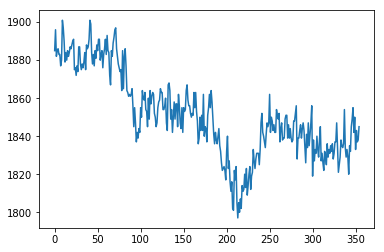

In [19]:
plt.plot(x,y)

In [99]:
"""Return subset of df determined by the indices of the row blocks
"""
def get_subsets(merged_df, row_blocks):
    tables = []
    column_names = ["Matlab_now", "A-DC1", "A-DC2", "A-DC3", "A-DC4", "A-DC5",
                    "A-DC6", "A-DC7", "A-DC8", "B-DC1", "B-DC2", "B-DC3", 
                    "B-DC4", "B-DC5", "B-DC6", "B-DC7", "B-DC8"]
    column_indices = [merged_df.columns.get_loc(c) for c in column_names]
    for row_block in row_blocks:
        df = merged_df.iloc[row_block[0]:row_block[1], column_indices]
        start_time = df.iloc[0]["Matlab_now"]
        df["Matlab_now"] = df["Matlab_now"] - start_time

        tables.append(df)
    return tables

In [64]:
tables = get_subsets(merged_df, easy_rows)

In [66]:
tables[0]

,Matlab_now,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,A-DC7,A-DC8,B-DC1,B-DC2,B-DC3,B-DC4,B-DC5,B-DC6,B-DC7,B-DC8
1111,0.000,1885.0,478.9,131.2,40.20,1800.0,441.0,110.2,28.98,283.4,78.32,23.93,6.913,378.8,114.7,36.36,12.69
1112,0.062,1896.0,472.0,131.3,40.10,1805.0,440.4,110.3,29.07,283.1,78.39,23.95,6.923,379.3,114.9,36.57,12.72
1113,0.126,1882.0,478.3,131.8,40.22,1804.0,441.7,110.8,28.86,283.2,78.54,24.04,6.928,379.2,114.9,36.41,12.75
1114,0.264,1885.0,474.8,131.1,40.17,1802.0,442.2,110.1,29.03,283.4,78.16,23.86,6.901,376.4,114.2,36.34,12.63
1115,0.329,1886.0,476.7,130.4,39.66,1804.0,440.2,110.7,28.92,282.5,78.16,23.85,6.905,376.6,114.0,36.10,12.65
1116,0.467,1883.0,473.3,130.6,39.77,1809.0,440.9,109.9,29.02,281.5,78.29,23.98,6.884,377.2,114.0,36.19,12.61
1117,0.533,1883.0,479.3,130.4,40.07,1806.0,441.3,111.0,29.10,283.0,78.31,23.89,6.879,376.5,114.4,36.26,12.61
1118,0.608,1877.0,475.9,130.0,40.21,1797.0,443.5,110.7,28.91,282.0,78.47,23.93,6.918,376.9,114.0,36.28,12.63
1119,0.670,1880.0,474.1,130.7,40.00,1805.0,442.0,111.2,29.12,282.7,78.57,23.93,6.910,377.8,114.3,36.52,12.69
1120,0.732,1901.0,475.7,130.8,40.19,1803.0,443.0,111.1,29.14,285.5,78.50,24.07,6.917,378.7,114.7,36.44,12.67


In [65]:
len(tables)

11

In [67]:
tables[0].columns

Index(['Matlab_now', 'A-DC1', 'A-DC2', 'A-DC3', 'A-DC4', 'A-DC5', 'A-DC6',
       'A-DC7', 'A-DC8', 'B-DC1', 'B-DC2', 'B-DC3', 'B-DC4', 'B-DC5', 'B-DC6',
       'B-DC7', 'B-DC8'],
      dtype='object')

In [108]:
"""Perform linear fit and calculate linear fit coefficients and mean
    :param table: pandas df, subset to examine
    :return: Dictionary of
                key: Column name
                value: 3-tuple (a, b, mean), where y = ax + b
"""
def extract_feature(table):
    x = table["Matlab_now"].values
    cols = table.columns[1:]
    my_dict = {}
    for col in cols:
        y = table[col].values
        z = np.poly1d(np.polyfit(x, y, 1))
        my_tuple = (z[1], z[0], table[col].mean())

        my_dict[col] = my_tuple
    return my_dict

In [111]:
z = extract_feature(tables[0])

In [112]:
z

{'A-DC1': (-1.9842354651893872, 1880.8585248359084, 1851.1723163841807),
 'A-DC2': (-0.5301678979574658, 474.2858131977439, 466.3539548022602),
 'A-DC3': (-0.11578820652272133, 130.28231095572477, 128.55000000000004),
 'A-DC4': (-0.03330549856153073, 39.74212640680521, 39.24384180790965),
 'A-DC5': (-0.39659092217314934, 1813.7752170196832, 1807.8418079096045),
 'A-DC6': (-0.10325662344159346, 443.99115323546437, 442.446327683616),
 'A-DC7': (0.02985239483493785, 111.44631524636513, 111.89293785310734),
 'A-DC8': (0.017358058826415817, 29.271011757212595, 29.53070621468929),
 'B-DC1': (0.007000307130488992, 282.81447722704513, 282.919209039548),
 'B-DC2': (0.016795465093594045, 78.37219710111297, 78.62347457627122),
 'B-DC3': (0.008587653676383767, 23.958807982092868, 24.08728813559324),
 'B-DC4': (0.0032137038508171832, 6.937710637279056, 6.985790960451977),
 'B-DC5': (-0.2249978219407768, 376.34699036596515, 372.98079096045194),
 'B-DC6': (-0.06979770910104614, 113.84961292635438, 11

In [193]:
"""
"""
def plot_feature(table, feature_dict, column_name):
    x = table["Matlab_now"]
    y1 = table[column_name]
    feature = feature_dict[column_name]
    y2 = feature[0] * x + feature[1]

    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.xlabel("time(s)")
    plt.ylabel("Light intensity")
    plt.title(column_name)
    plt.show()

In [207]:
"""
"""
def plot_feature(table, feature_dict, column_name):
    x = table["Matlab_now"]
    y1 = table[column_name]
    feature = feature_dict[column_name]
    y2 = feature[0] * x + feature[1]

    fig = plt.figure()
    ax = ax = fig.add_subplot(111)
    ax.plot(x, y1)
    ax.plot(x, y2)
    ax.set_xlabel("time(s)")
    ax.set_ylabel("Light intensity")
    ax.set_title(column_name)
    print(get_axis_limits(ax))
    #ax.annotate("text", get_axis_limits(ax))
    plt.show()

(28.243214999995434, 1715.5800000000002)


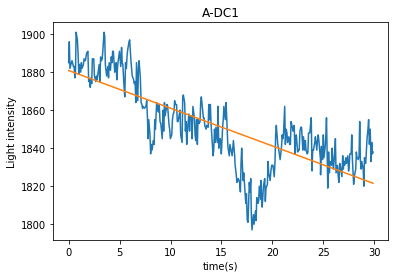

In [208]:
plot_feature(tables[0], z, "A-DC1")

In [187]:
def get_axis_limits(ax, scale=0.9):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

In [243]:
def plot_all_features(table, feature_dict):
    x = table["Matlab_now"]
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(45, 45))

    count = 0
    for row in ax:
        for col in row:
            if (count == len(table.columns[1:].values)):
                break
            column_name = table.columns[1:].values[count]
    
            feature = feature_dict[column_name]
            
            y1 = table[column_name]
            y2 = feature[0] * x + feature[1]
            #y3 = [feature[2] for _ in range(len(y1))]
            

            col.plot(x, y1)
            col.plot(x, y2)
            col.set_xlabel("time(s)")
            col.set_ylabel("Light intensity")
            col.title.set_text(column_name)
            #my_text1 = "y = %f*x + %f" % (feature[0], feature[1])
            #my_text2 = "mean = %f" % (feature[2])
            my_text1 = "y = {:9.4f}*x + {:9.4f}".format(feature[0], feature[1])
            my_text2 = "mean = {:9.4f}".format(feature[2])
            col.text(0.3, 0.9, my_text1 , transform=col.transAxes, size=20, weight='bold')
            col.text(0.3, 0.8, my_text2 , transform=col.transAxes, size=20, weight='bold')

            count += 1
    #return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale
    #ax1.annotate('A', xy=get_axis_limits(ax1))
    plt.savefig("fig1.png")
    plt.show()


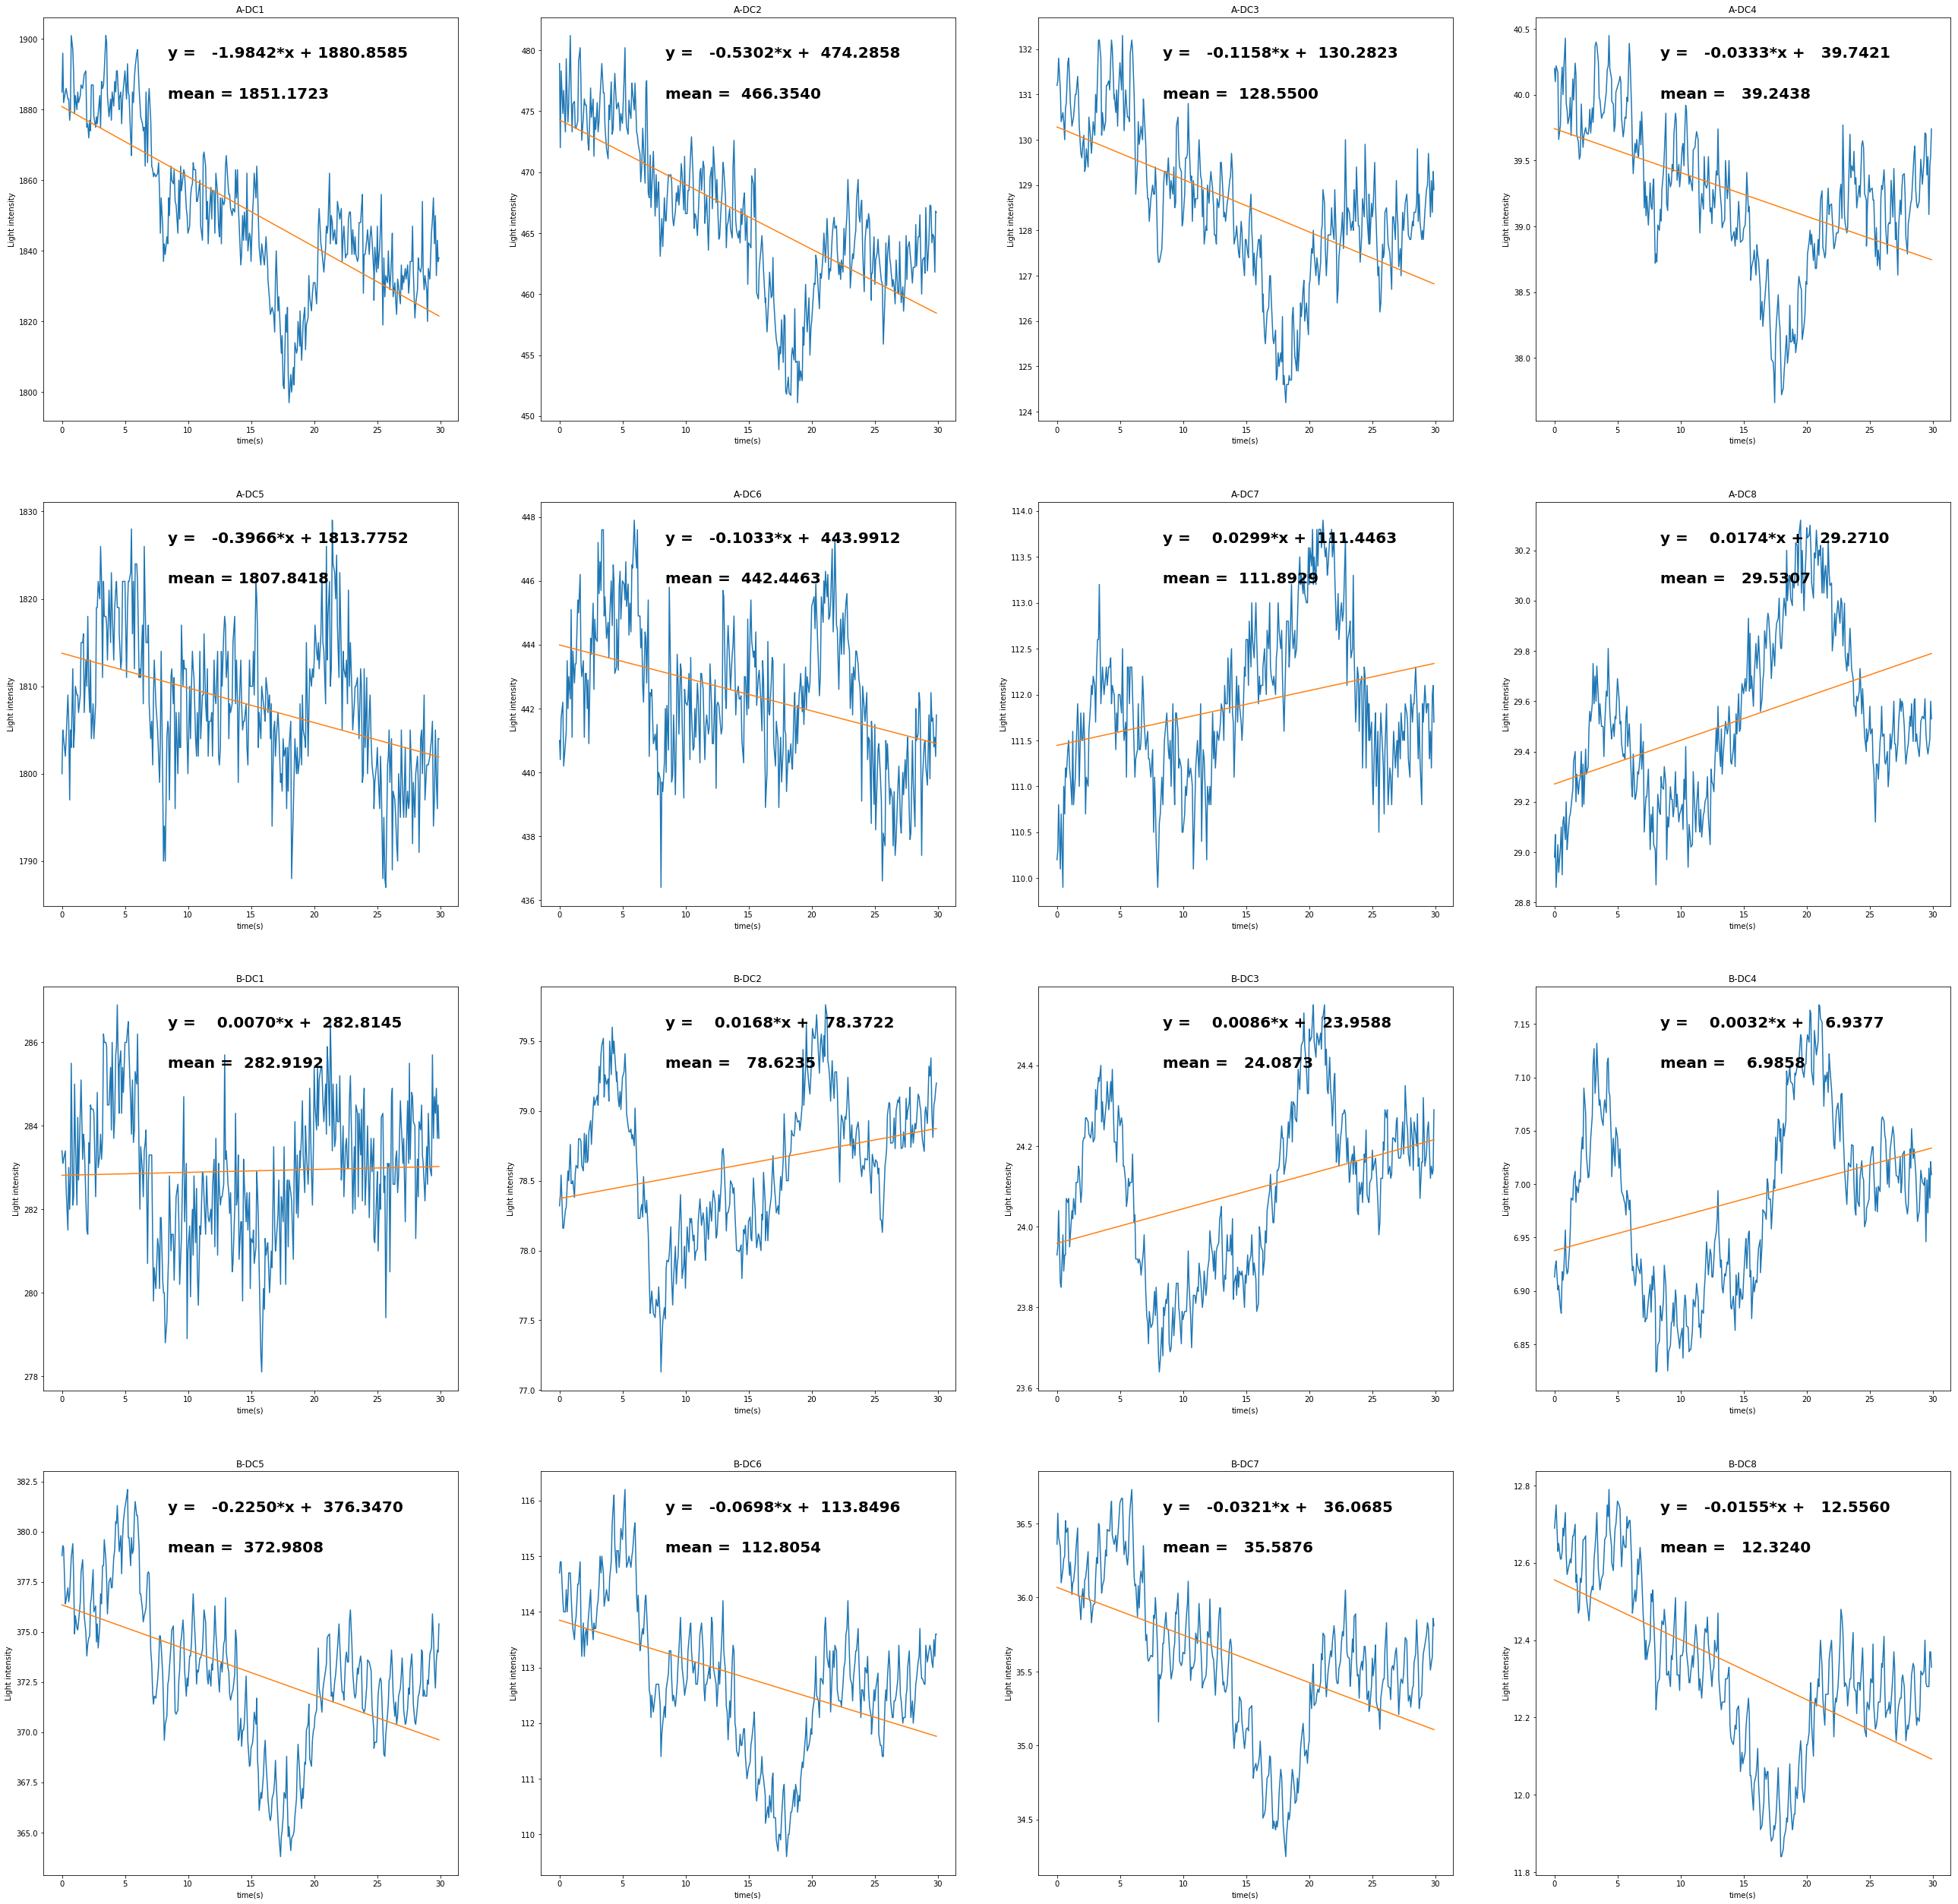

In [244]:
plot_all_features(tables[0], z)